# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from scipy.sparse import csr_matrix

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celherme1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celherme1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celherme1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [53]:
# Show df_content to get an idea of the data
df_content.head()

dtype('int64')

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

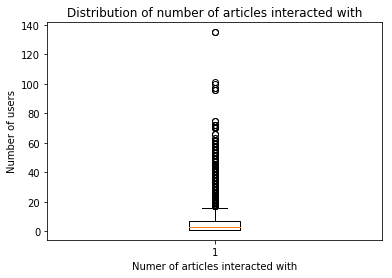

In [3]:
# We start by visualizing the distribution of how many articles a user interacts with in the dataset
# Important to count unique article ID's for each interaction is recorded
nb_interactions = df.groupby('email')['article_id'].nunique()
plt.axvline(x=nb_interactions.median())
plt.boxplot(nb_interactions)
plt.title('Distribution of number of articles interacted with')
plt.xlabel('Numer of articles interacted with')
plt.ylabel('Number of users');

The median maximum number of interactions between a specific article and a user is 1.0


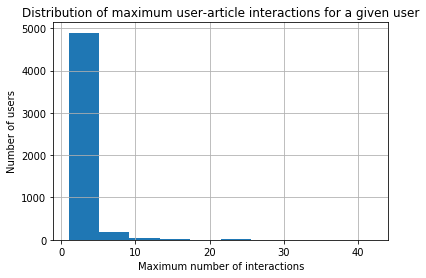

In [4]:
# for each user-article pair, we create a count of the number of interactions
# we create it in the form of a user-item matrix, with the values representing the number of interactions
user_article_mat = df.groupby(['email', 'article_id'])['email'].count().unstack()

# then we produce a numerical and visual summary
print('The median maximum number of interactions between a specific article and a user is {}'.format(user_article_mat.max(axis=1).median()))
user_article_mat.max(axis=1).hist()
plt.title('Distribution of maximum user-article interactions for a given user')
plt.xlabel('Maximum number of interactions')
plt.ylabel('Number of users');

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = nb_interactions.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article_mat.sum(axis=1).max() # The maximum number of user-article interactions by any 1 user is ______.

print('50% of individuals interact with {} number of articles or fewer.'.format(int(median_val)))
print('The maximum number of user-article interactions by any one user is {}'.format(int(max_views_by_user)))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any one user is 364


We can see most people only interact with 0-10 articles, but we have a very long tail, with a few people interacting with 100+ articles.

Looking at the number of user-article interactions (for a given user-article pair), many people only interact with articles at most only once. But for a few people, their maximum number of interactions with a given article is much greater, up to 42. The most prolific user has interacted with 364 articles.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
duplicated_article_id = df_content.loc[df_content.article_id.duplicated(),:]['article_id']
df_content.loc[df_content.article_id.isin(duplicated_article_id),:].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

The duplicates stem from articles with the same ID, same full name but different bodies or descriptions. The differences appear minimal, so we can safely keep only the first instance of each duplicate.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
# Number of unique articles that have an interaction with a user
# We simply take the number of unique article ID's in our df dataframe since it only records interactions
df.article_id.nunique()

714

In [9]:
# For the number of unique articles in the dataset, whether they have interactions or not, we look at our df_content data
df_content.article_id.nunique()

1051

In [10]:
# To get the number of unique users, we use our df dataset and examine the number of unique emails
df.email.nunique()

5148

In [11]:
# Finally, to get the number of user-article interactions in the dataset, it is simply the number of rows in df
df.shape[0]

45993

In [56]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

AttributeError: 'DataFrame' object has no attribute 'email'

Approximately 70% of our articles have been read by at least 1 user. We have 5148 users, and overall there have been 45,976 user-article interactions.

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
# To determine the most viewed article_id and the number of views, we use our user-article interactions matrix
print('The article with the most views is #{}, with {} views'.format(
    int(user_article_mat.sum().argmax()),
    int(user_article_mat.sum().max())))

The article with the most views is #1429, with 937 views


C:\Users\celherme1\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
most_viewed_article_id = user_article_mat.sum().argmax() # The most viewed article in the dataset as a string with one value following the decimal 
max_views = int(user_article_mat.sum().max()) # The most viewed article in the dataset was viewed how many times?

C:\Users\celherme1\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [55]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

KeyError: 'email'

In [33]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [34]:
# We check for missing values
print(df.isnull().sum())
print('\n')
print(df_content.isnull().sum())

article_id    0
title         0
user_id       0
dtype: int64


doc_body           14
doc_description     0
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


We are done with our data exploration. We notice that the doc body and descriptions are missing a few values, something we may have to take into account later in the analysis.

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [35]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_ids = get_top_article_ids(n, df)
    
    # we have to proceed through a for loop to keep the same order
    article_names = []
    top_articles = []
    
    # We first get a list of lists containing repetitions of the article name
    for id in top_ids:
        article_names.append(df.loc[df.article_id == id, 'title'].values.tolist())
    
    # then we make a new list with the unique values
    for names in article_names:
        top_articles.append(names[0])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id')['article_id'].count().sort_values(ascending=False).iloc[:n].index.tolist()
 
    return top_articles # Return the top article ids

In [36]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [37]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [38]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # We first create a matrix with null values where no user-article interaction, and 1 otherwise
    user_item_mat = df.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack()
    
    # then we replace the null values with 0
    user_item = user_item_mat.fillna(value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [39]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [40]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar user ID's
    
    '''
    similarity = []
    for user in range(1, user_item.shape[0]+1):
        sim = np.dot(user_item.loc[user_item.index == user_id,:].values, 
                     user_item.loc[user_item.index == user,:].values.T)[0][0]
        similarity.append((user, sim))
    
    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [i[0] for i in similarity]

    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users
        

In [41]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [44]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # We reuse code from part II
    
    # we have to proceed through a for loop to keep the same order
    article_rep_names = []
    article_names = []
    
    # We first get a list of lists containing repetitions of the article name
    for id in article_ids:
        article_rep_names.append(df.loc[df.article_id == float(id), 'title'].values.tolist())
    
    # then we make a new list with the unique values
    for names in article_rep_names:
        article_names.append(names[0])
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = user_item.loc[user_item.iloc[user_id-1],user_item.iloc[user_id-1] > 0].columns.values.tolist()
    
    article_names = get_article_names(article_ids)
    
    
    # we convert article_id's from floats to strings
    article_ids = [str(i) for i in article_ids]
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    # we first get the list of similar user_id
    similar_users = find_similar_users(user_id)
    
    # then we loop through it, finding the articles the user hasn't seen before
    for user in similar_users:
        if len(recs) > m:
            break
        ids, names = get_user_articles(user)
        # we only keep the ids the user hasn't interacted with, 
        # and append it to the recommendations if not already recommended
        ids = list(set(ids) - set(get_user_articles(user_id)[0]))
        for id in ids:
            if len(recs) > m:
                break
            if not id in recs:
                recs.append(id)
    
    return recs # return your recommendations for this user_id    

In [50]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

C:\Users\celherme1\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


['analyze open data sets with spark & pixiedust',
 'build a python app on the streaming analytics service',
 'this week in data science (may 2, 2017)',
 'brunel interactive visualizations in jupyter notebooks',
 'insights from new york car accident reports',
 'use decision optimization to schedule league games',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'learn basics about notebooks and apache spark',
 'using brunel in ipython/jupyter notebooks',
 'accelerate your workflow with dsx',
 'automating web analytics through python']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # we reuse a good chunk of the previous function which finds the neighbors
    
    similarity = []
    for user in range(1, user_item.shape[0]+1):
        sim = np.dot(user_item.loc[user_item.index == user_id,:].values, 
                     user_item.loc[user_item.index == user,:].values.T)[0][0]
        similarity.append((user, sim))

    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)

     # remove the own user's id
    similarity = [i for i in similarity if i[0] != user_id]
    
    # create list of just the ids, and a list of just similarity
    most_similar_users = [i[0] for i in similarity]
    highest_similarity = [i[1] for i in similarity]

    # we now get the total number of interactions for all these user ID's, in the same order
    interactions = []
    for user in most_similar_users:
        interactions.append(user_item.loc[user_item.index == user,:].sum(axis=1).values[0])
    
    # we finally form the dataframe and order it
    neighbors_df = pd.DataFrame({'neighbor_id': most_similar_users,
                                'similarity': highest_similarity,
                                'num_interactions': interactions})
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    rec_names = []
    
    # we start by getting the most similar users, ordered by the total number of interactions if same similarity score
    neighbors_df = get_top_sorted_users(user_id)
    
    # we create a dataframe with the number of interactions for each article
    article_interactions = user_item.sum(axis=0).values.tolist()
    article_ids = user_item.columns.values.tolist()
    
    nb_interactions = pd.DataFrame({'article_id': article_ids, 'nb_interactions': article_interactions})
    nb_interactions.sort_values('nb_interactions', ascending=False, inplace=True)
    
    # we now get the articles for each user, keep only those not seen by user of interest
    # order them based on total number of interactions  and use them to make recommendations
    for user in neighbors_df.neighbor_id:
        if len(recs) > m:
            break
        ids, _ = get_user_articles(user)
        ids = list(set(ids) - set(get_user_articles(user_id)[0]))
        ranked_articles = nb_interactions.loc[nb_interactions.article_id.isin(ids),'article_id']
        for id in ranked_articles:
            if len(recs) > m:
                break
            if not id in recs:
                recs.append(id)
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [29]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1429.0, 1314.0, 1271.0, 43.0, 1351.0, 1336.0, 1368.0, 151.0, 1338.0, 1162.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'healthcare python streaming application demo', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark', 'putting a human face on machine learning', 'jupyter notebook tutorial', 'ml optimization using cognitive assistant', 'analyze energy consumption in buildings']


C:\Users\celherme1\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [30]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0,0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10,0] # Find the 10th most similar user to user 131

In [31]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, we would have no interactions with any article. Given how our functions are written, this will raise an error when trying to find the closest neighbors, since this user is not present in our user-item matrix. We could artifically create a new row for new users, filling it with 0, but in this case the dot product of this new row with existing users would be 0 consistently, and we would have no basis to make recommendations.

Given the lack of information for these new users, our best bet is simply to predict the top articles, measured by the number of interactions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [32]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10)] # Your recommendations here

In [33]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to recommend articles based on similarity with existing articles. To do so, we first need to establish a method to calculate article similarity.

In [25]:
def tokenize(text):
    '''
    :param text: a string of text
    :return: a list of tokens for the text which has been normalized, stripped of stop words, tokenized and lemmatized
    '''

    # We first normalize the test
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)

    # Then we remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words("english")]

    # We instantiate our lemmatizer and apply it to all of our tokens
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [28]:
def make_content_recs(article_id, m=10, df_content=df_content, tokenizer=tokenize):
    '''
    INPUT:
    article_id - (int) the article we want to find similar articles to
    m - (int) the number of similar articles we want to find
    df_content - (Pandas dataframe) a dataframe containing content information about the article of interest
    
    OUTPUT:
    similar_articles - (list) a list of similar article ID's
    
    DESCRIPTION:
    We leverage the doc_description (good tradeoff between being descriptive and concise) and use NLP techniques along with
    cosine similarity measure to find documents most similar to one another
    '''
    # first, we drop the elements with missing doc_descriptions
    df_content.dropna(subset=['doc_description'], inplace=True)
    
    # we create a pipeline to do our processing
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenizer, stop_words='english')),
        ('tfidf', TfidfTransformer())
    ])
    
    # we get the representation of the doc and compute the cosine similarity between the doc and all the others
    transformed_text = pipeline.fit_transform(df_content.doc_description)
    article_idx = np.where(df_content.article_id == article_id)[0][0]
    similarity = cosine_similarity(transformed_text[article_idx], transformed_text)[0]
    
    # we can create a dictionary with the cosine similarity of each article with the article of interest
    similar_articles = dict()
    for idx in range(len(df_content)):
        similar_articles[df_content.iloc[idx]['article_id']] = similarity[idx])
    
    # we remove the own article, and return the keys associated with the highest value of similarity
    similar_articles.pop(article_id)
    similar_articles = sorted(similar_articles, key=similar_articles.get, reverse=True)[:m]
    
    return similar_articles

Our content-based recommendation system uses the information contained in the document description to make recommendations. More precisely, it first processes this information using a TF-IDF representation, and then uses cosine similarity to rank articles based on similarity. It then outputs the m articles most similar as recommended articles.

Currently, if the cosine similarity is the same for 2 articles (an edge case), the ranking of the recommendation will be arbitrary. Some possible future improvement would be to include total interactions for articles as a tie breaker. Another possible improvement would be to extend these methods to document description and document full name to have a more holistic vision of document similarity. Finally, we could explore other measures of similarity, such as Jaccard, to assess which metric is best for our use.

We can use our content-recommendation system to provide 10 articles from a single original article. For a given user, either we could pick this original article randomly amongst those she/he has interacted with, or we could pick the one with which the interaction were "best" (however this is measured - reading time, number of interactions etc...). For a brand new user, we would still recommend the top-ranked articles. We also need to make sure the article is present in the df_content - if not, we have no basis for content-based recommendations and must fall back on the top articles. This is the case for the last of the cases below.

In [29]:
# make recommendations based on article ID 40
article_id_40 = make_content_recs(40)

# make recommendations for a brand new user
new_users_recs = get_top_articles(10)

# make a recommendations for a user who only has interacted with article id '1427.0'
try:
    article_id_1427 = make_content_recs(1427)
except:
    article_id_1427 = get_top_articles(10)

print('Our recommendations for articles similar to article id 40 are {} \n'.format(article_id_40))
print('Our recommendations for a brand new users are {} \n'.format(new_users_recs))
print('Our recommendations for a user who has only interacted with article id 1427.0 are {} \n'.format(article_id_1427))

Our recommendations for articles similar to article id 40 are [384, 130, 32, 28, 759, 932, 16, 205, 55, 644] 

Our recommendations for a brand new users are ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model'] 

Our recommendations for a user who has only interacted with article id 1427.0 are ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'hea

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In this case we can apply the built-in Singular Value Decomposition for our matrix isn't sparse. The missing values are represented by 0's instead of missing values. This involves an underlying assumption that users, when they didn't interact with an article, do not like them rather than simply did not interact with them.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

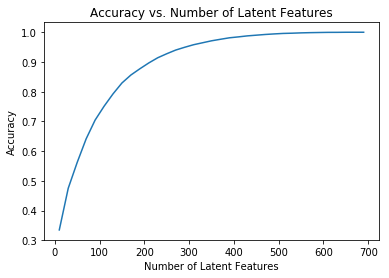

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # we leverage the function written above to create the user-item matrices
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
# number of users we can make predictions for in the test set
np.intersect1d(test_idx, df_train.user_id).size

20

In [43]:
# number of users in the test set we cannot make predictions for in the test set
# this is the cold start problem
np.setdiff1d(test_idx, df_train.user_id).size

662

In [44]:
# number of movies we can make predictions for in the test set
np.intersect1d(test_arts, df_train.article_id).size

574

In [45]:
# number of users in the test set we cannot make predictions for in the test set
# this is the cold start problem
np.setdiff1d(test_arts, df_train.article_id).size

0

In [46]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [47]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [48]:
# we isolate the users and movies for which we want to make predictions, and subset our u and v matrices matrix
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

# we also subset our user_item_test to only keep the rows for which we can make predictions
user_item_test = user_item_test.loc[user_item_test.index.isin(np.intersect1d(test_idx, df_train.user_id)),:]

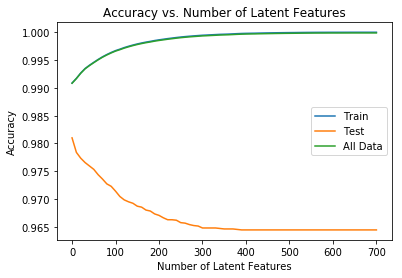

In [53]:
# we leverage chunk of code above to assess accuracy with respect of number of latent features
num_latent_feats = np.arange(0,700+10,10)
sum_errs_train = []
sum_errs_test = []
sum_all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    all_errs = err_train + err_test
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    sum_all_errs.append(all_errs)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, 1 - np.array(sum_all_errs)/(user_item_train.shape[0]*user_item_train.shape[1] \
                                                      + user_item_test.shape[0]*user_item_test.shape[1]), label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

While for our training set and overall our accuracy increases with the number of latent features, for the test set the inverse happens. Rather than being an issue with the algorithm itself, this is due to the very small overlap of users between test and train set. We only have 20 users in the test set, and for those, out of the 517 articles in the user-item matrix (so 20x517 = more than 10,000 interactions) there were only 218 interactions. This is not enough to accurately assess the performance of our recommender system.

As a result, I see two solutions:
- one of them is to switch the approach. This approach of creating a matrix with 0 and 1 implictly assumes a user that doesn't interact with an article does not rate it highly. I disagree with this assumption, and I believe a better approach is to use the number of interactions between a user and an article as a proxy for a rating, leave the other cells as null, and leverage FunkSVD to make recommendations. This is the approach I will take in the class I will create eventually for this project
- should we want to keep this approach, rather than rely on offline testing we could switch to **online** testing, through an experiment. One idea could be to design an A/B test, with the control group being exposed to no recommender system (or the current implementation, depending on what the baseline is) and the treatment group receiving our new system. In this case, our metric of interest could be the number of articles a user interacts with during a certain timeframe (week, month...), scaled by time spent on platform. This would give us a good idea of the actual performance of our recommender system "in the wild", but this will require a lot of resources to deploy the finalized model, design, conduct and analyze the experiment, which is why, when feasible, offline testing is always a good idea.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [50]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0